In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

Load the text extraction data (assuming multiple cluster files) and the video engagement data.

In [2]:
# Specify the folder containing the cluster files
cluster_folder = 'text_clusters'  # Replace with the actual folder path

# List all CSV files in the folder
cluster_files = [os.path.join(cluster_folder, f) for f in os.listdir(cluster_folder) if f.endswith('.csv')]

# Print the list of files to verify
print("Cluster Files Found:")
print(cluster_files)

Cluster Files Found:
['text_clusters\\df_cluster_0.csv', 'text_clusters\\df_cluster_1.csv', 'text_clusters\\df_cluster_2.csv', 'text_clusters\\df_cluster_3.csv', 'text_clusters\\df_cluster_4.csv', 'text_clusters\\df_cluster_5.csv']


In [3]:
# Combine all cluster data into one DataFrame
text_data = pd.concat([pd.read_csv(file) for file in cluster_files], ignore_index=True)

# Load video engagement data
video_data = pd.read_csv('results_count_with_error.csv')

In [4]:
# Display the first few rows of both datasets
print("\nText Extraction Data:")
print(text_data.head())
print("\nNumber of rows and columns in text_data:", text_data.shape)

print("\nVideo Engagement Data:")
print(video_data.head())
print("\nNumber of rows and columns in video_data:", video_data.shape)


Text Extraction Data:
      Video ID                               text_cleaned  cluster  \
0  TeMYei9-L3I                     HOW TO DRINK RED HORSE        0   
1  7YUatj_Uq6c           TOP 10 PLACES TO SEE PHILIPPINES        0   
2  Q7teS12VJfg                              ANGELICA HALE        0   
3  QG61j-coCgM  THE MIRACLE OF T16 ICONIC ESPORTS MOMENTS        0   
4  z9K8LE9lgqA                DAY 1 HEL DAY 2 THE PEOPLE.        0   

   x0_Bert-CLS  x1_Bert-CLS  
0     2.089855    -1.174470  
1     1.764231    -1.594547  
2     1.416814    -1.715946  
3     1.863088    -2.554374  
4     1.518131    -0.203527  

Number of rows and columns in text_data: (2938, 5)

Video Engagement Data:
       VideoID  View Count  Like Count  Comment Count
0  lZXDClzL8m8     4885860       75940           3507
1  XsWKvutlu8I     3545247       55237           1656
2  stMSVi5wI8k     3824080       67281           2274
3  b7HQU_--Qdw      596295       10123            831
4  zDwuJgLNJbc     4322068    

In [5]:
# Merge datasets on VideoID, renaming 'Video ID' in text_data to match 'VideoID' in video_data
# First rename the column in text_data
text_data = text_data.rename(columns={'Video ID': 'VideoID'})

# Now merge using the consistent column name
merged_data = pd.merge(text_data, video_data, on='VideoID', how='inner')

# Check the merged dataset
print("\nMerged Dataset:")
print(merged_data.head())

# Display the number of rows and columns
print("\nNumber of rows and columns:", merged_data.shape)


Merged Dataset:
       VideoID                               text_cleaned  cluster  \
0  TeMYei9-L3I                     HOW TO DRINK RED HORSE        0   
1  7YUatj_Uq6c           TOP 10 PLACES TO SEE PHILIPPINES        0   
2  Q7teS12VJfg                              ANGELICA HALE        0   
3  QG61j-coCgM  THE MIRACLE OF T16 ICONIC ESPORTS MOMENTS        0   
4  z9K8LE9lgqA                DAY 1 HEL DAY 2 THE PEOPLE.        0   

   x0_Bert-CLS  x1_Bert-CLS  View Count  Like Count  Comment Count  
0     2.089855    -1.174470        3864         296             95  
1     1.764231    -1.594547       27166        1415             43  
2     1.416814    -1.715946       16090         613             58  
3     1.863088    -2.554374     1825759       16723           1736  
4     1.518131    -0.203527       13262         489             52  

Number of rows and columns: (2440, 8)


In [6]:
# Group by cluster and calculate total and average engagement metrics
cluster_summary = merged_data.groupby('cluster').agg(
    Total_Views=('View Count', 'sum'),
    Avg_Views=('View Count', 'mean'),
    Total_Likes=('Like Count', 'sum'),
    Avg_Likes=('Like Count', 'mean'),
    Total_Comments=('Comment Count', 'sum'),
    Avg_Comments=('Comment Count', 'mean')
).reset_index()

# Display the summary
print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
   cluster  Total_Views     Avg_Views  Total_Likes    Avg_Likes  \
0        0    229628931  3.005614e+05      5854608  7663.099476   
1        1     65872706  1.441416e+05      1969263  4309.109409   
2        2     43198709  1.380150e+05      1169457  3736.284345   
3        3    470869428  1.401397e+06      2955638  8796.541667   
4        4     16310115  1.019382e+05       393989  2462.431250   
5        5     75456219  1.840396e+05      1542189  3761.436585   

   Total_Comments  Avg_Comments  
0          302856    396.408377  
1          205541    449.761488  
2           88158    281.654952  
3          172010    511.934524  
4           33976    212.350000  
5          128444    313.278049  


## ANOVA Correlation

In [13]:
## ANOVA Analysis for Text Clusters

# Define the metrics we'll analyze
metric_columns = ['View Count', 'Like Count', 'Comment Count']
print(f"Analyzing metrics: {', '.join(metric_columns)}")

# Set significance level
alpha = 0.05

Analyzing metrics: View Count, Like Count, Comment Count


In [14]:
# Function to identify and remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create masks for outliers and non-outliers
    outlier_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    # Return dataframes with and without outliers
    return df[~outlier_mask], df[outlier_mask]

# Create dictionaries to store clean data and outliers
clean_data = {}
outliers = {}

Outlier Analysis - Views:
Original data points: 2440
After outlier removal: 2137
Outliers removed: 303 (12.4%)


C:\Users\yesha\AppData\Local\Temp\ipykernel_67760\1321021626.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='View Count', data=merged_data, ax=ax1, palette='Set2')
C:\Users\yesha\AppData\Local\Temp\ipykernel_67760\1321021626.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], ax=ax2, palette='Set2')


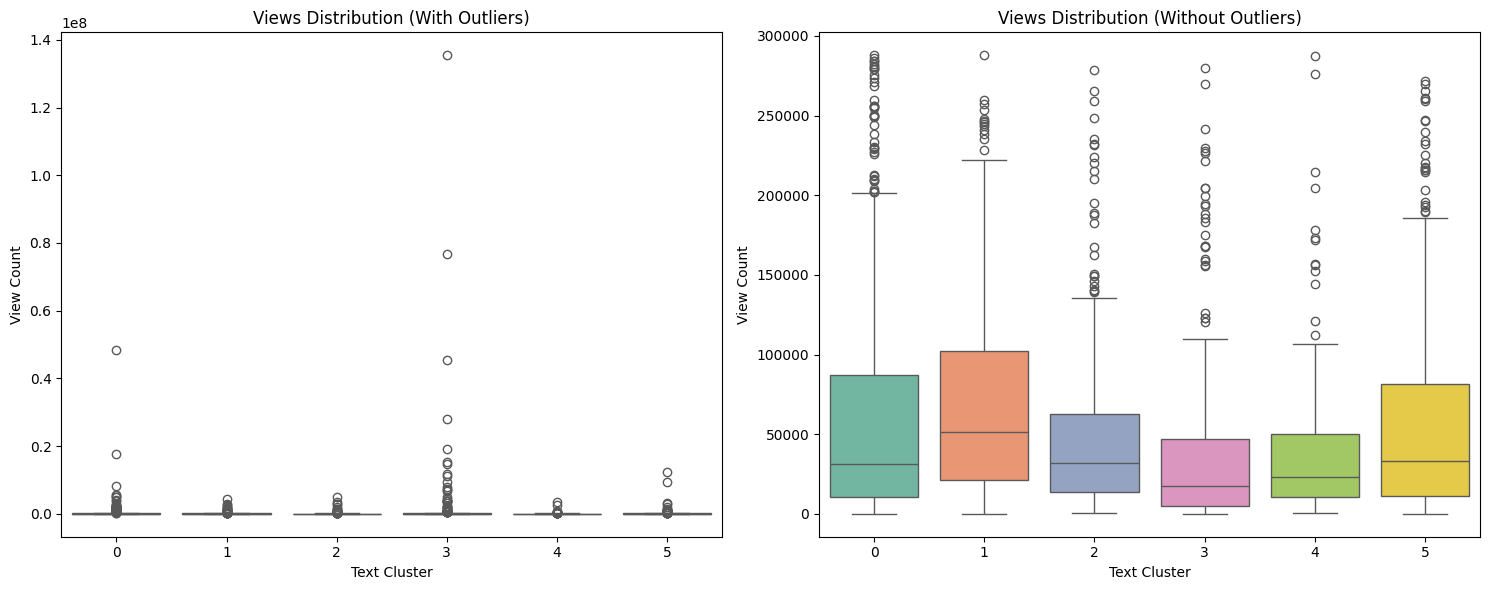

In [15]:
# Remove outliers for View Count
clean_data['View Count'], outliers['View Count'] = remove_outliers(merged_data, 'View Count')

print("Outlier Analysis - Views:")
print(f"Original data points: {len(merged_data)}")
print(f"After outlier removal: {len(clean_data['View Count'])}")
print(f"Outliers removed: {len(outliers['View Count'])} ({len(outliers['View Count'])/len(merged_data)*100:.1f}%)")

# Visualize distribution before and after outlier removal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
sns.boxplot(x='cluster', y='View Count', data=merged_data, ax=ax1, palette='Set2')
ax1.set_title('Views Distribution (With Outliers)')
ax1.set_xlabel('Text Cluster')
ax1.set_ylabel('View Count')

# After outlier removal
sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], ax=ax2, palette='Set2')
ax2.set_title('Views Distribution (Without Outliers)')
ax2.set_xlabel('Text Cluster')
ax2.set_ylabel('View Count')

plt.tight_layout()
plt.show()

Outlier Analysis - Likes:
Original data points: 2440
After outlier removal: 2146
Outliers removed: 294 (12.0%)


C:\Users\yesha\AppData\Local\Temp\ipykernel_67760\2246965847.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Like Count', data=merged_data, ax=ax1, palette='Set2')
C:\Users\yesha\AppData\Local\Temp\ipykernel_67760\2246965847.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], ax=ax2, palette='Set2')


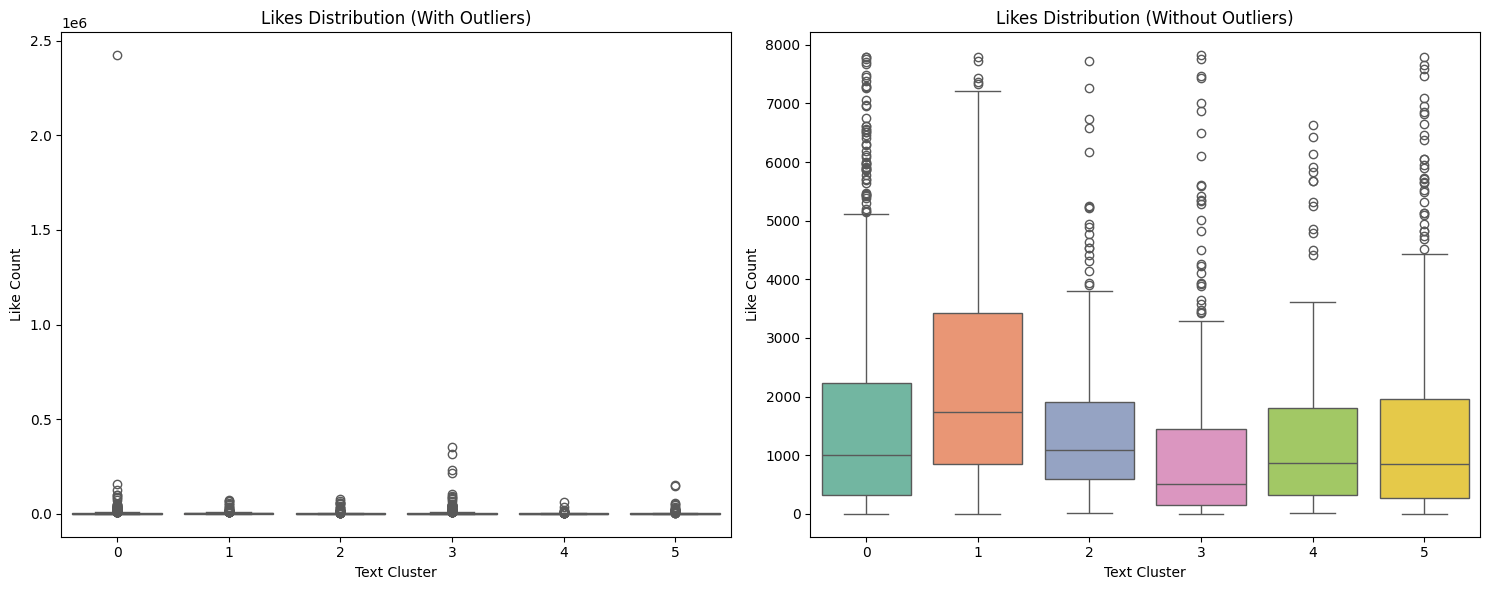

In [16]:
# Remove outliers for Like Count
clean_data['Like Count'], outliers['Like Count'] = remove_outliers(merged_data, 'Like Count')

print("Outlier Analysis - Likes:")
print(f"Original data points: {len(merged_data)}")
print(f"After outlier removal: {len(clean_data['Like Count'])}")
print(f"Outliers removed: {len(outliers['Like Count'])} ({len(outliers['Like Count'])/len(merged_data)*100:.1f}%)")

# Visualize distribution before and after outlier removal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
sns.boxplot(x='cluster', y='Like Count', data=merged_data, ax=ax1, palette='Set2')
ax1.set_title('Likes Distribution (With Outliers)')
ax1.set_xlabel('Text Cluster')
ax1.set_ylabel('Like Count')

# After outlier removal
sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], ax=ax2, palette='Set2')
ax2.set_title('Likes Distribution (Without Outliers)')
ax2.set_xlabel('Text Cluster')
ax2.set_ylabel('Like Count')

plt.tight_layout()
plt.show()

Outlier Analysis - Comments:
Original data points: 2440
After outlier removal: 2193
Outliers removed: 247 (10.1%)


C:\Users\yesha\AppData\Local\Temp\ipykernel_67760\2573769111.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Comment Count', data=merged_data, ax=ax1, palette='Set2')
C:\Users\yesha\AppData\Local\Temp\ipykernel_67760\2573769111.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], ax=ax2, palette='Set2')


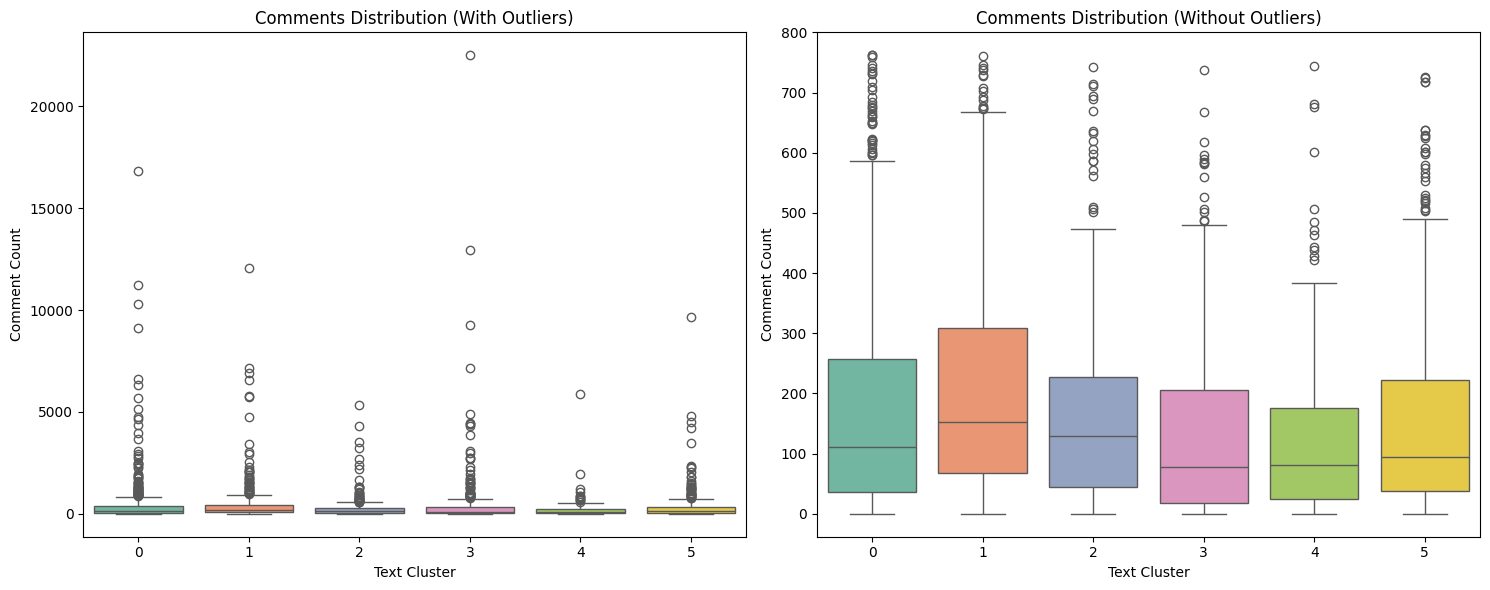

In [17]:
# Remove outliers for Comment Count
clean_data['Comment Count'], outliers['Comment Count'] = remove_outliers(merged_data, 'Comment Count')

print("Outlier Analysis - Comments:")
print(f"Original data points: {len(merged_data)}")
print(f"After outlier removal: {len(clean_data['Comment Count'])}")
print(f"Outliers removed: {len(outliers['Comment Count'])} ({len(outliers['Comment Count'])/len(merged_data)*100:.1f}%)")

# Visualize distribution before and after outlier removal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before outlier removal
sns.boxplot(x='cluster', y='Comment Count', data=merged_data, ax=ax1, palette='Set2')
ax1.set_title('Comments Distribution (With Outliers)')
ax1.set_xlabel('Text Cluster')
ax1.set_ylabel('Comment Count')

# After outlier removal
sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], ax=ax2, palette='Set2')
ax2.set_title('Comments Distribution (Without Outliers)')
ax2.set_xlabel('Text Cluster')
ax2.set_ylabel('Comment Count')

plt.tight_layout()
plt.show()

In [18]:
# Group cleaned data by cluster for ANOVA analysis
views_by_cluster = []
likes_by_cluster = []
comments_by_cluster = []

# Create clusters for ANOVA
for cluster_id in sorted(merged_data['cluster'].unique()):
    # Get data for this cluster with outliers removed
    cluster_views = clean_data['View Count'][clean_data['View Count']['cluster'] == cluster_id]['View Count'].values
    views_by_cluster.append(cluster_views)
    
    cluster_likes = clean_data['Like Count'][clean_data['Like Count']['cluster'] == cluster_id]['Like Count'].values
    likes_by_cluster.append(cluster_likes)
    
    cluster_comments = clean_data['Comment Count'][clean_data['Comment Count']['cluster'] == cluster_id]['Comment Count'].values
    comments_by_cluster.append(cluster_comments)
    
    # Print some info about the data we're using
    print(f"Cluster {cluster_id} (after outlier removal):")
    print(f"  Views: {len(cluster_views)} videos")
    print(f"  Likes: {len(cluster_likes)} videos")
    print(f"  Comments: {len(cluster_comments)} videos")

Cluster 0 (after outlier removal):
  Views: 649 videos
  Likes: 662 videos
  Comments: 687 videos
Cluster 1 (after outlier removal):
  Views: 415 videos
  Likes: 402 videos
  Comments: 402 videos
Cluster 2 (after outlier removal):
  Views: 287 videos
  Likes: 281 videos
  Comments: 291 videos
Cluster 3 (after outlier removal):
  Views: 274 videos
  Likes: 283 videos
  Comments: 288 videos
Cluster 4 (after outlier removal):
  Views: 150 videos
  Likes: 151 videos
  Comments: 152 videos
Cluster 5 (after outlier removal):
  Views: 362 videos
  Likes: 367 videos
  Comments: 373 videos


In [19]:
# Perform ANOVA test on Views
anova_views = f_oneway(*views_by_cluster)

print("## ANOVA Results for Views ##")
print(f"F-statistic: {anova_views.statistic:.4f}")
print(f"p-value: {anova_views.pvalue:.4e}")

if anova_views.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Views across text clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Views across text clusters (p > {alpha}).")

## ANOVA Results for Views ##
F-statistic: 10.2858
p-value: 9.2654e-10
RESULT: There are statistically significant differences in Views across text clusters (p < 0.05).


C:\Users\yesha\AppData\Local\Temp\ipykernel_67760\4203132139.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], palette='Set2')


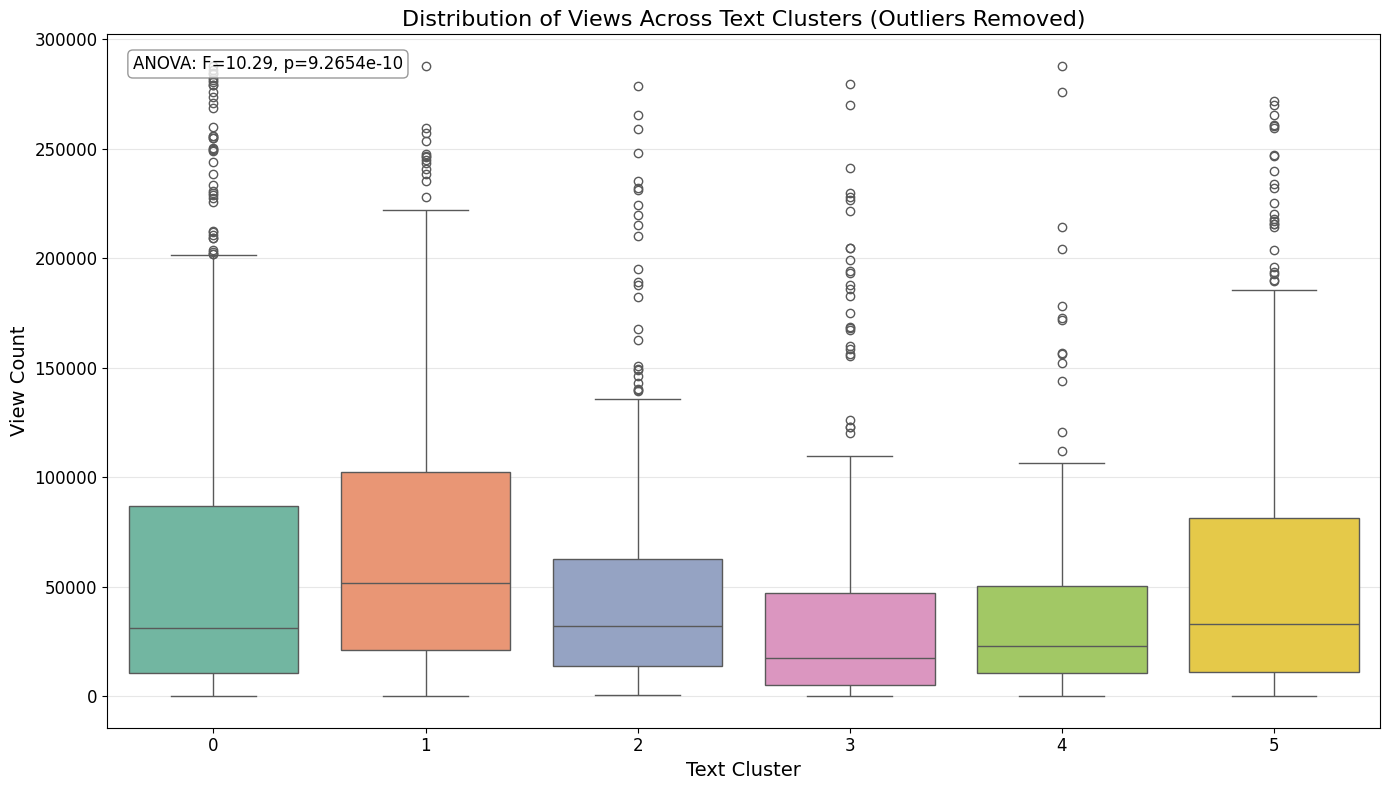

In [21]:
# Create boxplot for Views distribution by cluster
plt.figure(figsize=(14, 8))

# Create the boxplot
sns.boxplot(x='cluster', y='View Count', data=clean_data['View Count'], palette='Set2')


# Style the plot
plt.title('Distribution of Views Across Text Clusters (Outliers Removed)', fontsize=16)
plt.xlabel('Text Cluster', fontsize=14)
plt.ylabel('View Count', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_views.statistic:.2f}, p={anova_views.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()

In [22]:
# Perform ANOVA test on Likes
anova_likes = f_oneway(*likes_by_cluster)

print("## ANOVA Results for Likes ##")
print(f"F-statistic: {anova_likes.statistic:.4f}")
print(f"p-value: {anova_likes.pvalue:.4e}")

if anova_likes.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Likes across text clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Likes across text clusters (p > {alpha}).")

## ANOVA Results for Likes ##
F-statistic: 19.3810
p-value: 6.4488e-19
RESULT: There are statistically significant differences in Likes across text clusters (p < 0.05).


C:\Users\yesha\AppData\Local\Temp\ipykernel_67760\1990300238.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], palette='Set2')


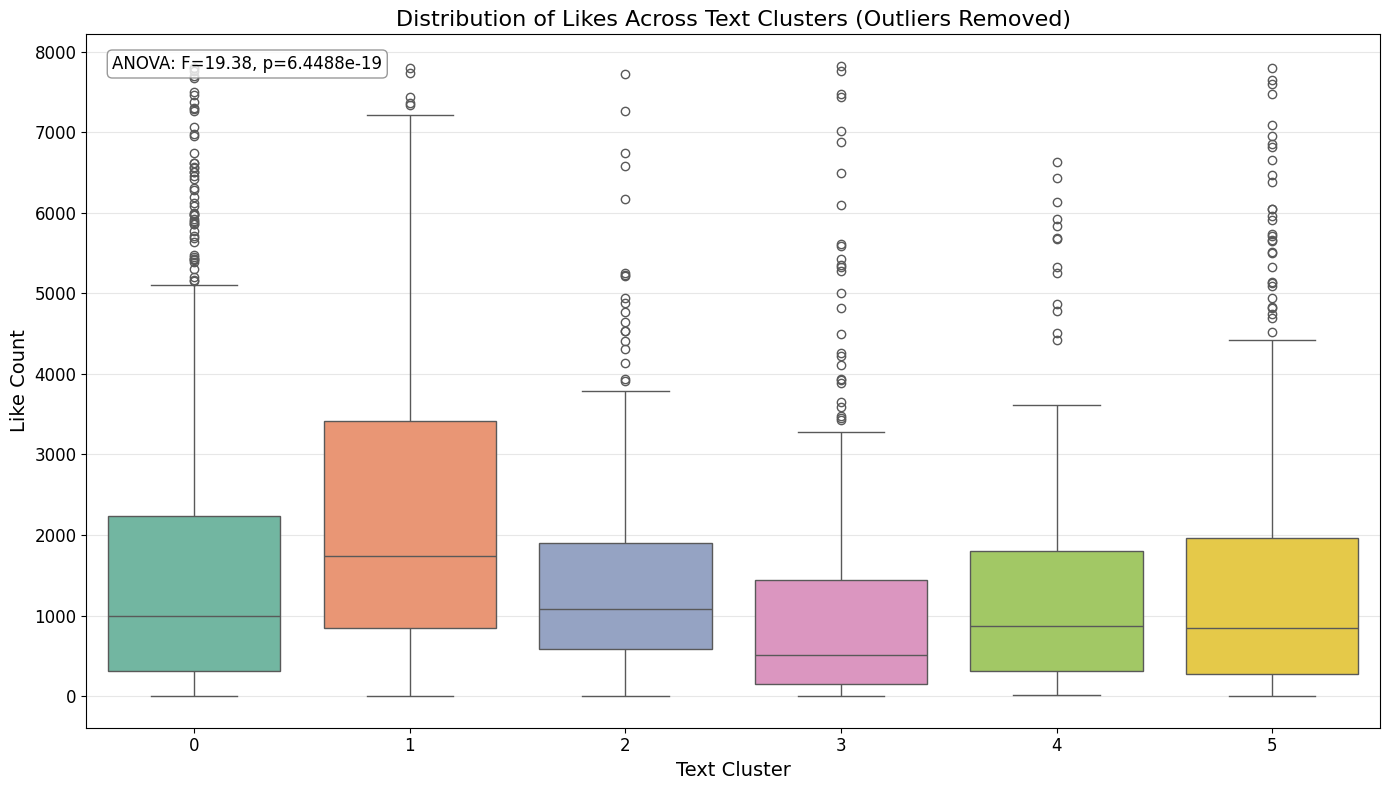

In [24]:
# Create boxplot for Likes distribution by cluster
plt.figure(figsize=(14, 8))

# Create the boxplot
sns.boxplot(x='cluster', y='Like Count', data=clean_data['Like Count'], palette='Set2')


# Style the plot
plt.title('Distribution of Likes Across Text Clusters (Outliers Removed)', fontsize=16)
plt.xlabel('Text Cluster', fontsize=14)
plt.ylabel('Like Count', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_likes.statistic:.2f}, p={anova_likes.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()

In [25]:
# Perform ANOVA test on Comments
anova_comments = f_oneway(*comments_by_cluster)

print("## ANOVA Results for Comments ##")
print(f"F-statistic: {anova_comments.statistic:.4f}")
print(f"p-value: {anova_comments.pvalue:.4e}")

if anova_comments.pvalue < alpha:
    print(f"RESULT: There are statistically significant differences in Comments across text clusters (p < {alpha}).")
else:
    print(f"RESULT: No significant differences in Comments across text clusters (p > {alpha}).")

## ANOVA Results for Comments ##
F-statistic: 9.3892
p-value: 7.2486e-09
RESULT: There are statistically significant differences in Comments across text clusters (p < 0.05).


C:\Users\yesha\AppData\Local\Temp\ipykernel_67760\1842981975.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], palette='Set2')


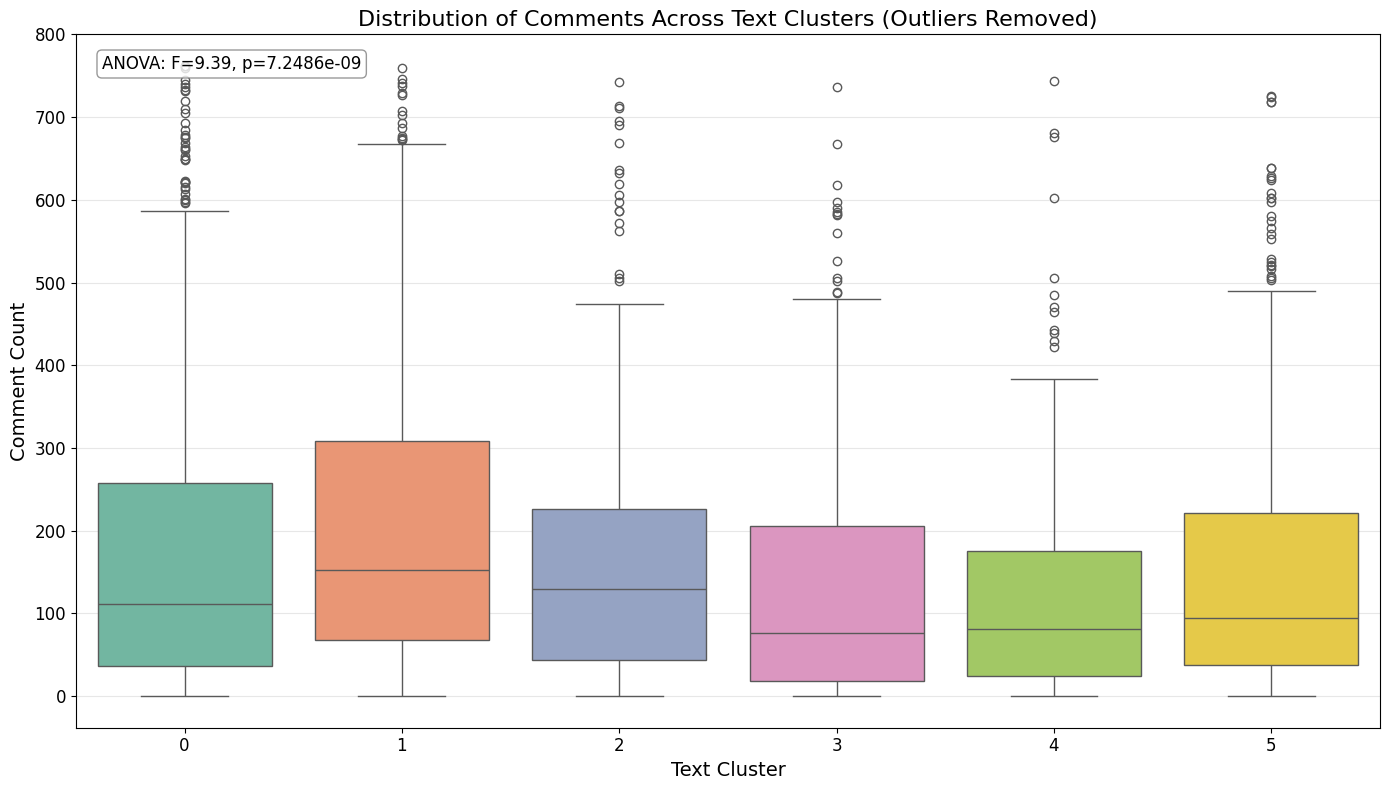

In [27]:
# Create boxplot for Comments distribution by cluster
plt.figure(figsize=(14, 8))

# Create the boxplot
sns.boxplot(x='cluster', y='Comment Count', data=clean_data['Comment Count'], palette='Set2')


# Style the plot
plt.title('Distribution of Comments Across Text Clusters (Outliers Removed)', fontsize=16)
plt.xlabel('Text Cluster', fontsize=14)
plt.ylabel('Comment Count', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add annotation with ANOVA result
plt.annotate(f'ANOVA: F={anova_comments.statistic:.2f}, p={anova_comments.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))


plt.tight_layout()
plt.show()